# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.106319,True,5.675343
1,0.359100,False,0.987123
2,-0.124612,False,-1.519267
3,1.447542,True,8.749332
4,1.385710,False,2.580976
...,...,...,...
995,0.354799,False,1.182566
996,0.146796,False,-0.469998
997,2.438290,True,10.491947
998,-0.603578,True,3.547517


<Axes: xlabel='v0'>

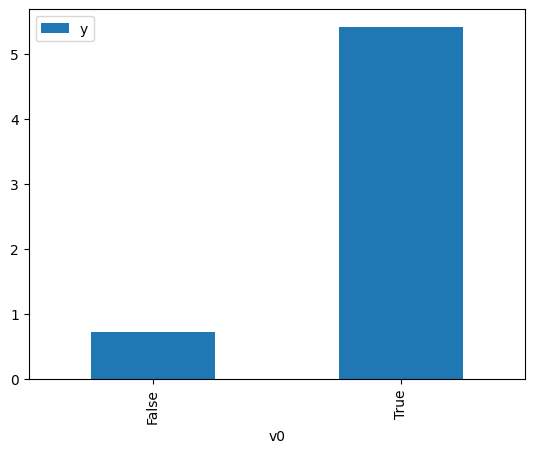

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

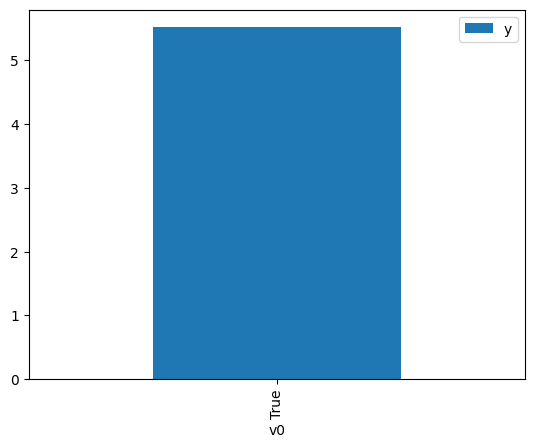

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-1.534422,False,-3.108471,0.610739,1.637361
1,-1.117955,False,-2.914213,0.579816,1.724686
2,-0.356266,False,1.329371,0.521781,1.916513
3,2.147615,False,5.660720,0.335191,2.983373
4,-0.353381,False,-1.767459,0.521559,1.917329
...,...,...,...,...,...
995,-0.041405,False,-0.177609,0.497526,2.009946
996,0.614818,False,1.785888,0.447144,2.236418
997,-0.602715,False,-0.948071,0.540700,1.849453
998,0.094280,False,-0.696038,0.487070,2.053091


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,1.717895,True,9.074209,0.634672,1.575618
1,-0.711732,True,2.818028,0.450965,2.217468
2,1.355248,True,6.668879,0.608379,1.643713
3,1.023566,True,8.584745,0.583763,1.713024
4,-2.001660,True,0.550912,0.355609,2.812079
...,...,...,...,...,...
995,-1.207070,True,3.052582,0.413505,2.418348
996,0.396034,True,6.520597,0.536128,1.865226
997,1.058598,True,7.818169,0.586385,1.705364
998,1.101061,True,7.144221,0.589557,1.696190


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.956
Model:                            OLS   Adj. R-squared (uncentered):              0.956
Method:                 Least Squares   F-statistic:                          1.074e+04
Date:                Sun, 03 Dec 2023   Prob (F-statistic):                        0.00
Time:                        07:24:25   Log-Likelihood:                         -1439.2
No. Observations:                1000   AIC:                                      2882.
Df Residuals:                     998   BIC:                                      2892.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.1406      0.033     65.283      0.000       2.076       2.205
x2             5.0254      0.046    108.293      0.000       4.934       5.116
==============================================================================
Omnibus:                        1.724   Durbin-Watson:                   2.050
Prob(Omnibus):                  0.422   Jarque-Bera (JB):                1.800
Skew:                          -0.090   Prob(JB):                        0.407
Kurtosis:                       2.895   Cond. No.                         1.57
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""